# 3D image segmentation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from my_utils import *

---

Same as the visualization, first we need to load the reference, tumor and liver images and process the frames that included other information that we descarted.

In [3]:
REFERENCE_IMAGE_FOLDER = '../data/31_EQP_Ax5.00mm/'
TUMOR_IMAGE_FILE = '../data/31_EQP_Ax5.00mm_ManualROI_Tumor.dcm'
LIVER_IMAGE_FILE = '../data/31_EQP_Ax5.00mm_ManualROI_Liver.dcm'

In [4]:
reference_img = load_image(REFERENCE_IMAGE_FOLDER)
reference_img = reference_img[:-1]
reference_img = reference_img[::-1]

def find_index(target):
    for i, frame in enumerate(reference_img):
        if frame.ImagePositionPatient[2] == target:
            return i
    return None

tumor_img = pydicom.dcmread(TUMOR_IMAGE_FILE)
tumor_mask = np.zeros_like(np.array([item.pixel_array for item in reference_img]))

for i, frame in enumerate(tumor_img.PerFrameFunctionalGroupsSequence):
    position_patient = frame.PlanePositionSequence[0].ImagePositionPatient[2]  # get z
    # search position patient index
    idx = find_index(position_patient)
    if idx is None:
        print("Can't find matching position patient", position_patient)
    tumor_mask[idx] = tumor_img.pixel_array[i]

liver_img = pydicom.dcmread(LIVER_IMAGE_FILE)
liver_mask = np.zeros_like(np.array([item.pixel_array for item in reference_img]))

for i, frame in enumerate(liver_img.PerFrameFunctionalGroupsSequence):
    position_patient = frame.PlanePositionSequence[0].ImagePositionPatient[2]  # get z
    # search position patient index
    idx = find_index(position_patient)
    if idx is None:
        print("Can't find matching position patient", position_patient)
    liver_mask[idx] = liver_img.pixel_array[i]

volume = np.stack([s.pixel_array for s in reference_img], axis=0)

Now, we get the 3D bounding box of the tumor, not the 2D used to get the bounding box of the projection, and the centroid.

In [5]:
indices = np.argwhere(tumor_mask > 0)

if indices.size == 0:
    print("No tumor voxels found.")
else:
    # 3D bounding box: min and max for each axis (z, y, x)
    zmin, ymin, xmin = indices.min(axis=0)
    zmax, ymax, xmax = indices.max(axis=0)
    bbox = ((zmin, ymin, xmin), (zmax, ymax, xmax))

    # Centroid: mean of the indices
    centroid = indices.mean(axis=0)

    print("Bounding box (z,y,x):", bbox)
    print("Centroid (z,y,x):", centroid)

Bounding box (z,y,x): ((np.int64(33), np.int64(246), np.int64(96)), (np.int64(43), np.int64(312), np.int64(157)))
Centroid (z,y,x): [ 37.90876974 278.48246052 125.5024522 ]


With the centroid, we will apply a region growing algorithm in order to try to segment the tumor.

The implementation of the region growing uses the 6-conectivity of the adjacent voxels and uses a queue to store the voxels to process. It is not limited by any iteration restriction.

In [6]:
from collections import deque

def region_growing_3d(volume, seed, threshold=30):
    shape = volume.shape
    segmentation = np.zeros(shape, dtype=np.uint8)
    visited = np.zeros(shape, dtype=bool)
    seed = tuple(int(round(x)) for x in seed)
    seed_val = volume[seed]
    queue = deque([seed])
    visited[seed] = True
    segmentation[seed] = 1

    # 6-connectivity (adjacent voxels)
    neighbors = [(-1,0,0),(1,0,0),(0,-1,0),(0,1,0),(0,0,-1),(0,0,1)]

    while queue:
        z, y, x = queue.popleft()
        for dz, dy, dx in neighbors:
            nz, ny, nx = z+dz, y+dy, x+dx
            if 0 <= nz < shape[0] and 0 <= ny < shape[1] and 0 <= nx < shape[2]:
                if not visited[nz, ny, nx]:
                    if abs(int(volume[nz, ny, nx]) - int(seed_val)) <= threshold:
                        segmentation[nz, ny, nx] = 1
                        queue.append((nz, ny, nx))
                    visited[nz, ny, nx] = True
    return segmentation

region_growing_segmentation = region_growing_3d(volume, centroid, threshold=10)

Once we have computed the segmentation, we need to use some metrics to evaluate how good is the segmentation.



In [7]:
def dice_coefficient(mask1, mask2):
    """
    Compute the Dice coefficient between two binary masks.
    """
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)
    intersection = np.logical_and(mask1, mask2).sum()
    size1 = mask1.sum()
    size2 = mask2.sum()
    if size1 + size2 == 0:
        return 1.0  # Both masks are empty
    return 2. * intersection / (size1 + size2)

In [8]:

dice_score = dice_coefficient(tumor_mask, region_growing_segmentation)
dice_loss = 1 - dice_score
print(f"Dice coefficient: {dice_score:.4f}")
print(f"Dice loss: {dice_loss:.4f}")

Dice coefficient: 0.0653
Dice loss: 0.9347


The obtained dice coefficient is very low, it means the overlaping between the tumor mask and the segmentation is very bad. Let's visualize how it's segmented.

GIF saved at ../results/segmentation/reference_coronal-sagittal_rotation_seg.gif


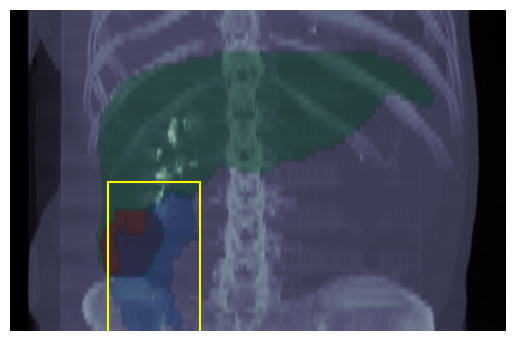

In [9]:
coronal_sagittal_seg_rotation2(reference_img, tumor_mask, liver_mask, region_growing_segmentation, "")

We can see that a big part of the segmented volume is wrongly segmented. We can try to optimize the threshold parameter of the ragion growing in order to improve the segmentation.

We do that by performing a search grid from 1 to 30.

Best threshold: 10, Dice coefficient: 0.0653


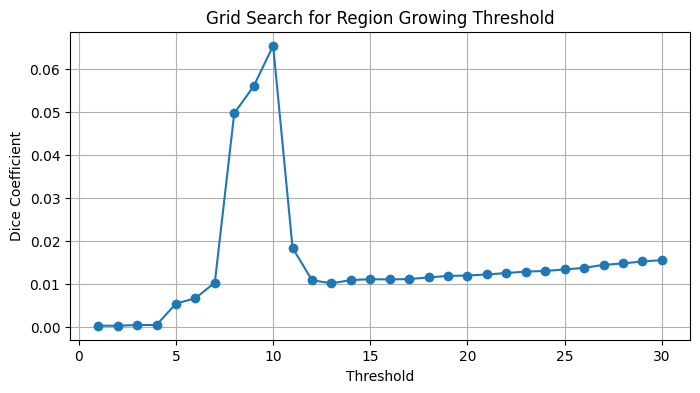

In [10]:
dice_scores = []
thresholds = range(1, 31)

for t in thresholds:
    seg = region_growing_3d(volume, centroid, threshold=t)
    score = dice_coefficient(tumor_mask, seg)
    dice_scores.append(score)

best_idx = np.argmax(dice_scores)
best_threshold = thresholds[best_idx]
best_dice = dice_scores[best_idx]

print(f"Best threshold: {best_threshold}, Dice coefficient: {best_dice:.4f}")

plt.figure(figsize=(8, 4))
plt.plot(thresholds, dice_scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Dice Coefficient')
plt.title('Grid Search for Region Growing Threshold')
plt.grid(True)
plt.show()

We already tried (by luck) the best threshold to achieve the highest dice coefficient.

What can we do to improve the segmentation?

One simple idea is since we have the bounding box, we can use it to limit the segmentation.

In [11]:
from collections import deque

def region_growing_3d_limited_area(volume, seed, min_bbox, max_bbox, threshold=30):
    xmin, ymin, zmin = min_bbox
    xmax, ymax, zmax = max_bbox

    shape = volume.shape
    segmentation = np.zeros(shape, dtype=np.uint8)
    visited = np.zeros(shape, dtype=bool)
    seed = tuple(int(round(x)) for x in seed)
    seed_val = volume[seed]
    queue = deque([seed])
    visited[seed] = True
    segmentation[seed] = 1

    # 6-connectivity (adjacent voxels)
    neighbors = [(-1,0,0),(1,0,0),(0,-1,0),(0,1,0),(0,0,-1),(0,0,1)]

    while queue:
        z, y, x = queue.popleft()
        for dz, dy, dx in neighbors:
            nz, ny, nx = z+dz, y+dy, x+dx
            if nx < xmin or xmax < nx or \
                    ny < ymin or ymax < ny or \
                    nz < zmin or zmax < nz:
                continue

            if 0 <= nz < shape[0] and 0 <= ny < shape[1] and 0 <= nx < shape[2]:
                if not visited[nz, ny, nx]:
                    if abs(int(volume[nz, ny, nx]) - int(seed_val)) <= threshold:
                        segmentation[nz, ny, nx] = 1
                        queue.append((nz, ny, nx))
                    visited[nz, ny, nx] = True
    return segmentation

In [12]:
region_growing_segmentation = region_growing_3d_limited_area(
    volume, centroid, (xmin, ymin, zmin), (xmax, ymax, zmax), threshold=10)

GIF saved at ../results/segmentation/reference_coronal-sagittal_rotation_seg.gif


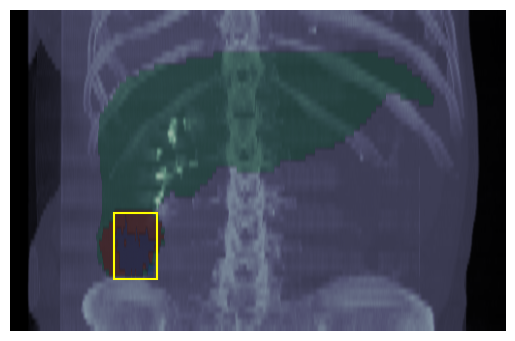

In [13]:
coronal_sagittal_seg_rotation2(reference_img, tumor_mask, liver_mask, region_growing_segmentation, "")

In [14]:
dice_score = dice_coefficient(tumor_mask, region_growing_segmentation)
dice_loss = 1 - dice_score
print(f"Dice coefficient: {dice_score:.4f}")
print(f"Dice loss: {dice_loss:.4f}")

Dice coefficient: 0.0801
Dice loss: 0.9199


In [15]:
def compute_metrics(gt_mask, pred_mask):
    """
    Compute precision, recall, accuracy, and f1-score for binary masks.
    """
    gt = gt_mask.astype(bool)
    pred = pred_mask.astype(bool)

    tp = np.logical_and(gt, pred).sum()
    tn = np.logical_and(~gt, ~pred).sum()
    fp = np.logical_and(~gt, pred).sum()
    fn = np.logical_and(gt, ~pred).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return precision, recall, accuracy, f1, tp, tn, fp, fn

precision, recall, accuracy, f1, tp, tn, fp, fn \
    = compute_metrics(tumor_mask, region_growing_segmentation)
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"F1-score:  {f1:.4f}")
print("----")
print(f"TP:        {tp}")
print(f"TN:        {tn}")
print(f"FP:        {fp}")
print(f"FN:        {fn}")

Precision: 0.9627
Recall:    0.0418
Accuracy:  0.9983
F1-score:  0.0801
----
TP:        1006
TN:        13869533
FP:        39
FN:        23054


Our method have high precision and accuracy, it make sence since we've limited the region to the bounding box form the tumor mask. The growing will not go ouside the bounding box, that reduces a lot the chances to make mistakes.

Taking this into account, we should be loking to the recall. Since the main problem is not make mistakes because we already have the zone controlled, but to see how much of the tumor we really get to segment. However, it's metrics are really low.

Since we know the resolution per voxel in mm, we can compute how much we are missing from the tumor.

In [16]:
voxel = 0.798828 * 0.798828 * 5.0

In [17]:
print("Well segmented:", tp * voxel)
print("Bad segmented: ", fp * voxel)
print("Not segmented: ", fn * voxel)

Well segmented: 3209.7746531275193
Bad segmented:  124.43460384887999
Not segmented:  73556.80402902767
